# Simulation of Optical Coherent System for QPSK Single Channel Single Polarization

In [937]:
"""
Cleaned up version of the integration imports we need to actually run this code together.
"""

import numpy as np
from optic.models.devices import mzm, photodiode, edfa, iqm, coherentReceiver, pdmCoherentReceiver, basicLaserModel
from optic.models.channels import linearFiberChannel, ssfm
from optic.comm.modulation import modulateGray, grayMapping
from optic.comm.sources import bitSource, symbolSource
from optic.dsp.core import upsample, pulseShape, pnorm, anorm, signalPower, firFilter, decimate, symbolSync,phaseNoise

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W, ber2Qfactor
from optic.plot import eyediagram, pconst, plotPSD
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp
import scipy.constants as const

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.dsp.equalization import edc, mimoAdaptEqualizer, ffe
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM, bert
from optic.dsp.clockRecovery import gardnerClockRecovery


import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)
import time

In [938]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Transmitter Code

In [939]:
"""
Single-channel QPSK coherent transmitter using OptiCommPy's IQM
(patterned after optic.models.tx.simpleWDMTx).

What you get:
- symbTx: QPSK symbols (unit-energy constellation by design)
- sigTx: pulse-shaped complex baseband (normalized to peak amplitude 1)
- sigLO: complex optical carrier field (unit amplitude, optional phase noise)
- sigTxo: modulated optical field at the transmitter output, with desired launch power
"""

# -------------------------
# 1) User parameters
# -------------------------
SpS = 16              # samples per symbol
Rs = 32e9             # symbol rate [baud]
Fs = Rs * SpS         # sampling frequency [Hz]
M = 4                 # QPSK -> M=4, constType='qam'

nBits = 400000        # total bits to generate
rollOff = 0.01        # RRC roll-off
nFilterTaps = 1024    # RRC filter taps

mzmScale = 0.5        # IQM drive scale (OptiCommPy default)
P_launch_dBm = -2     # desired launched optical power [dBm]
laserLinewidth = 100e3   # Hz (set e.g. 100e3 for phase noise), setting laserLineWidth to 0, models the ideal case 

# -------------------------
# 1) Symbol generation (QPSK)
# -------------------------
# In OptiCommPy, symbolSource() generates constellation symbols.
# With constType='qam' and M=4 -> QPSK. The symbol sequence is complex.
paramSymb = parameters()
paramSymb.nSymbols = int(nBits // np.log2(M))  # symbols = bits / log2(M)
paramSymb.M = M
paramSymb.constType = "qam"                    # 'qam' with M=4 -> QPSK
paramSymb.dist = "uniform"                     # uniform symbol probabilities
paramSymb.seed = 123
paramSymb.shapingFactor = 0

constSymb = grayMapping(paramSymb.M, paramSymb.constType)
if paramSymb.dist == "uniform":
   px = np.ones(paramSymb.M) / paramSymb.M
elif paramSymb.probDist == "maxwell-boltzmann":
   px = np.exp(-paramSymb.shapingFactor * np.abs(constSymb) ** 2)
   px = px / np.sum(px)
else:
   raise ValueError("Invalid probability distribution.")
paramSymb.px = px

symbTx = symbolSource(paramSymb)               # shape: (nSymbols,)


In [940]:
# -------------------------
# 2) Upsampling + pulse shaping (RRC)
# -------------------------
# Upsampling inserts SpS-1 zeros between symbols, then FIR filtering applies RRC.
paramPulse = parameters()
paramPulse.pulseType = "rrc"
paramPulse.nFilterTaps = nFilterTaps
paramPulse.rollOff = rollOff
paramPulse.SpS = SpS

pulse = pulseShape(paramPulse)                 # RRC impulse response

symbolsUp = upsample(symbTx, SpS)              # shape: (nSymbols*SpS,)
sigTx = firFilter(pulse, symbolsUp)            # pulse-shaped baseband waveform

# normalize waveform to peak amplitude 1 (NOT RMS). This makes drive scaling predictable.
sigTx = sigTx / np.max(np.abs(sigTx)) 


In [941]:
# -------------------------
# 3) Optical carrier / LO field (Ein)
# -------------------------
# OptiCommPy's simpleWDMTx creates a unit-amplitude optical field with optional phase noise:
# Ein(t) = exp(j*phi_pn(t)). This is then IQ-modulated.
if laserLinewidth and laserLinewidth > 0:
    phi_pn = phaseNoise(laserLinewidth, len(sigTx), 1 / Fs, seed=123)
    sigLO = np.exp(1j * phi_pn)
else:
    sigLO = np.ones_like(sigTx, dtype=complex)


In [942]:
# -------------------------
# 4) IQ modulation using IQM
# -------------------------
# Drive signal u(t) is dimensionless in this convention:
# u(t) = mzmScale * sigTx(t)
# mzmScale is the "modulation depth" knob (documented as ~ Vrf/Vpi).

paramIQM = parameters()
paramIQM.Vpi = 2
paramIQM.VbI = -2
paramIQM.VbQ = -2
paramIQM.Vphi = 1

u_drive = mzmScale * sigTx
sigTxo = iqm(sigLO, u_drive, paramIQM)   # complex optical field at IQM output (still normalized power)


In [943]:
# -------------------------
# 5) Set launched optical power
# -------------------------
# pnorm() normalizes the optical field so that mean(|E|^2)=1.
# Then multiplying by sqrt(P) sets mean optical power to P (watts).
P_launch_W = dBm2W(P_launch_dBm)
sigTxo = np.sqrt(P_launch_W) * pnorm(sigTxo)

In [944]:
# -------------------------
# 6) Quick sanity checks
# -------------------------
print("nSymbols =", len(symbTx))
print("Waveform length =", len(sigTx), "samples")
print("Fs =", Fs/1e9, "GHz")
print("Drive max|u| =", np.max(np.abs(u_drive)))      # should be ~ mzmScale (since peak(sigTx)=1)
print("Launch power (W) ~", np.mean(np.abs(sigTxo)**2), "(target:", P_launch_W, ")")

nSymbols = 200000
Waveform length = 3200000 samples
Fs = 512.0 GHz
Drive max|u| = 0.5
Launch power (W) ~ 0.000630957344480276 (target: 0.0006309573444801933 )


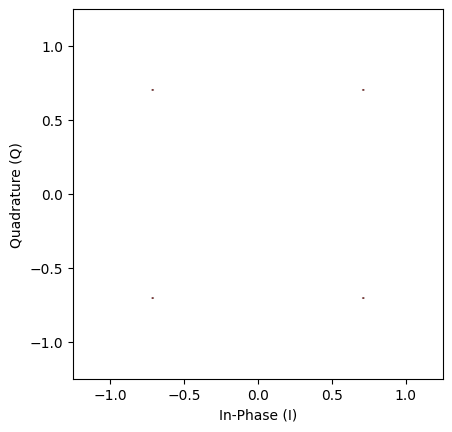

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [945]:
# CONSTELLATION DIAGRAM AFTER SYMBOL MAPPING WITH OPTICOMMPY LIBRARY FUNCTION

# plotting constellation diagram after symbol mapping
pconst(symbTx, lim=True, R=1.25, pType='fancy', cmap='turbo', whiteb=True)

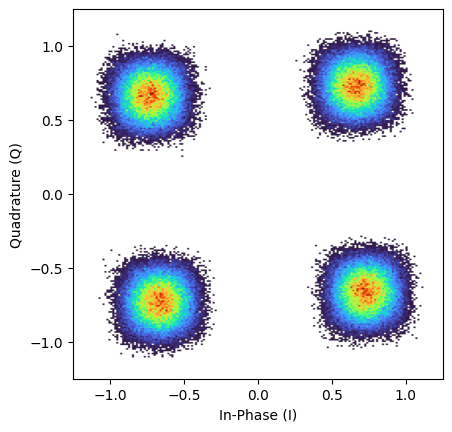

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [946]:
# CONSTELLATION DIAGRAM AFTER PULSE SHAPING (DAC) -> ANALOGUE WAVEFORM

# after pulse shapping
gd = (nFilterTaps - 1)//2
discard = gd + 200*SpS
z = sigTx[discard:-discard]
z_sym = z[::SpS]

# remove scale/rotation for display
n = min(len(z_sym), len(symbTx))
g = np.vdot(symbTx[:n], z_sym[:n]) / np.vdot(symbTx[:n], symbTx[:n])
z_eq = z_sym / g

pconst(z_eq, lim=True, R=1.25, pType='fancy')

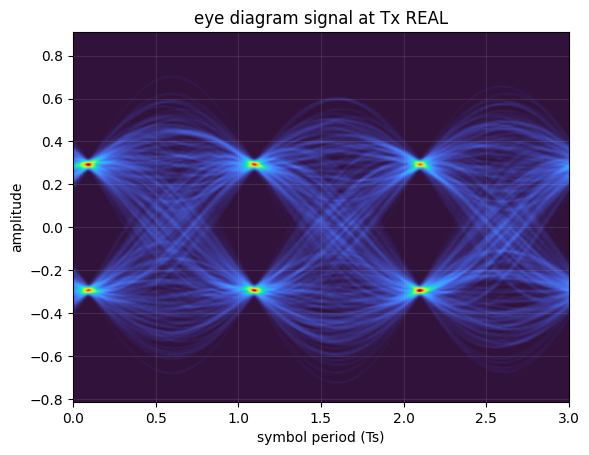

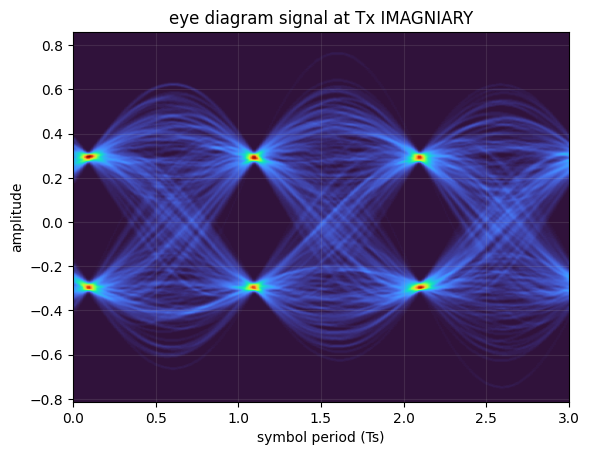

[-0.3111569  -0.29953054 -0.28847057 ... -0.45788169 -0.39679653
 -0.32809196]
3192578


'\nThe Eye Diagrams for both I and Q axis are plotted. \nThe amplitude swings between -0.3 and +0.3, effectively crossing the 0-axix and creating an eye height of 0.6\nEach Eye Diagram therefore has 2 distinct amplitude levels: 2 * 2 = 4 symbols, thereofre validating the QPSK configuration of the system\nThe Eye Diagrams are evaluated at the Tx side (before optical modulation) to ensure that the transmitted signal meets the criteria before entering the channel\n'

In [947]:
# EYE DIAGRAMS AFTER PULSE SHAPPING AND BEFORE IQM

# plotting eye diagrams of sigTx
iscard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigTx.real[discard:-discard], sigTx.real.size-2*discard, SpS, plotlabel='signal at Tx REAL', ptype='fancy')
eyediagram(sigTx.imag[discard:-discard], sigTx.imag.size-2*discard, SpS, plotlabel='signal at Tx IMAGNIARY', ptype='fancy')
print(sigTx.real[discard:-discard])
print(sigTx.imag.size-2*discard)

# ==== Plot validation ====
"""
The Eye Diagrams for both I and Q axis are plotted. 
The amplitude swings between -0.3 and +0.3, effectively crossing the 0-axix and creating an eye height of 0.6
Each Eye Diagram therefore has 2 distinct amplitude levels: 2 * 2 = 4 symbols, thereofre validating the QPSK configuration of the system
The Eye Diagrams are evaluated at the Tx side (before optical modulation) to ensure that the transmitted signal meets the criteria before entering the channel
"""

In [948]:
# CREATING TIME INTERVAL FOR PSD AND TIME PLOTS

#From simpleWDMTx Ts
# interval and time
# transmitter parameters
Ts = 1 / Rs  # symbol period [s]
interval = np.arange(16*20, 16*50)
t = interval * Ts / 1e-9

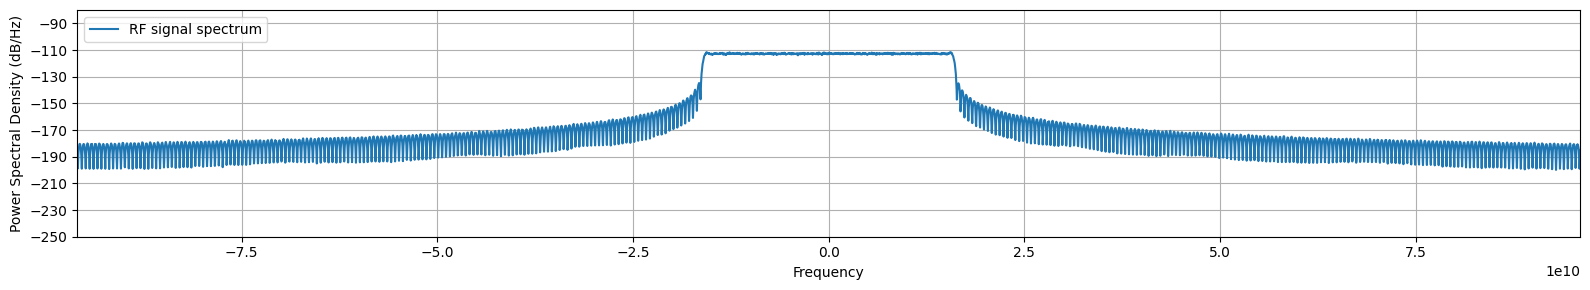

'\nThe RRC Filter Spectrum has a bandwidth of: B = Rs/2 * (1 + a)\nTherefore the theoretical/expected bandwidth is B = 10e9/2 * (1+0.01) = 5.05*10e8 Herz\nFrom the graph we read off aproximately 0.5 * 1e10  Herz\nAs a result theory matches expectation\n\nIt is important to mention the effect of the size of the FFT (N) in pulse shapping. \nA higher N leads to:\n       - higher accuracy\n       - reduced side lobes (out of band emissions)\n       - minimized ISI by decreasing corss-talk between adjacent symbols\n       - increases computational complexity and effort\nAs a conclusion: a larger FFT allows for more precise frequenct-domain shaping, creating a tigher (more dense spectrum) \nand less interference, but increases the computational load\n'

In [949]:
# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-250, -80)
ax.psd(sigTx, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='RF signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# ==== Plot validation ====
"""
The RRC Filter Spectrum has a bandwidth of: B = Rs/2 * (1 + a)
Therefore the theoretical/expected bandwidth is B = 10e9/2 * (1+0.01) = 5.05*10e8 Herz
From the graph we read off aproximately 0.5 * 1e10  Herz
As a result theory matches expectation

It is important to mention the effect of the size of the FFT (N) in pulse shapping. 
A higher N leads to:
       - higher accuracy
       - reduced side lobes (out of band emissions)
       - minimized ISI by decreasing corss-talk between adjacent symbols
       - increases computational complexity and effort
As a conclusion: a larger FFT allows for more precise frequenct-domain shaping, creating a tigher (more dense spectrum) 
and less interference, but increases the computational load
"""


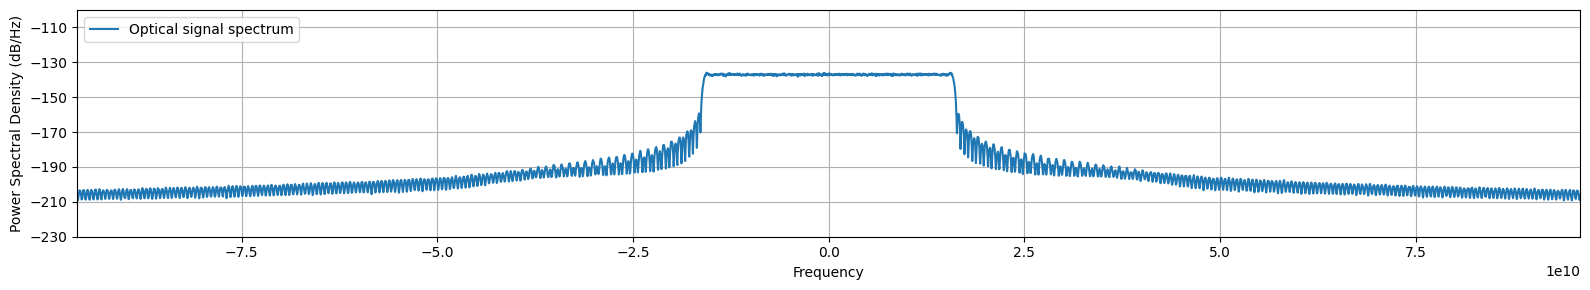

In [950]:
# ===== Optical PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

# switch between sigTxo and np.abs(sigTxo)**2

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-230, -100)
ax.psd(sigTxo, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='Optical signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

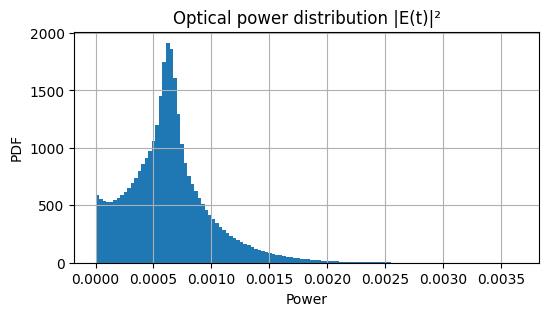

In [951]:
# ===== Optical Power Histogram =====
Pmid = np.abs(sigTxo)**2
Pmid = Pmid[discard:-discard]

plt.figure(figsize=(6,3))
plt.hist(Pmid, bins=120, density=True)
plt.title("Optical power distribution |E(t)|²")
plt.xlabel("Power"); plt.ylabel("PDF")
plt.grid(True)

# Channel Code

In [952]:
"""
Created a non-linear single polarization channel 
"""
# --------------------------------------
# 1) Optical Channel Set up and ssfm Function
# -------------------------------------
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 400     # total link distance [km]
paramCh.Lspan  = 40      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = 193.1e12      # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.prgsBar = True   # show progress bar
paramCh.Fs = Rs*SpS # sampling rate
paramCh.amp = 'edfa'
paramCh.NF = 4.5
#paramCh.seed = 456

sigCh = ssfm(sigTxo, paramCh)



  0%|          | 0/10 [00:00<?, ?it/s]

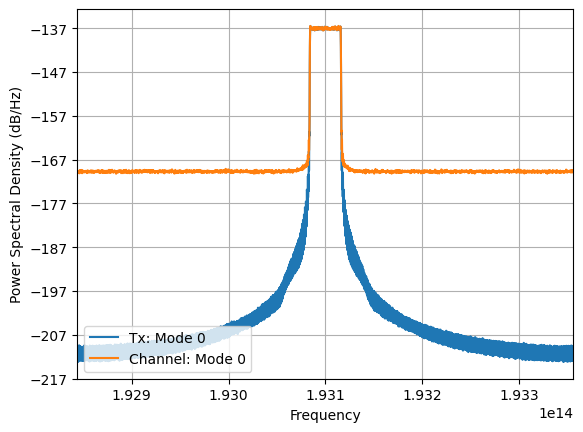

In [953]:
# plot psd
Fs = paramCh.Fs
fig = plotPSD(sigTxo, Fs, paramCh.Fc, label='Tx'); 
fig = plotPSD(sigCh, Fs, paramCh.Fc, fig=fig, label='Channel');
ax.set_title('Optical Spectrum');

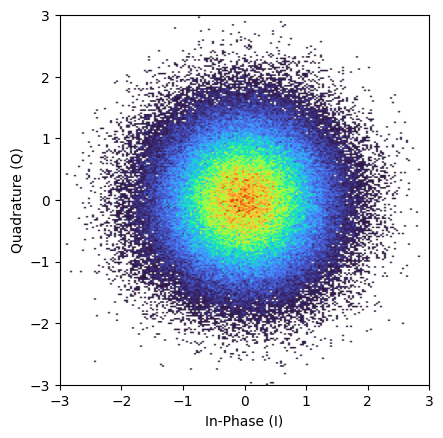

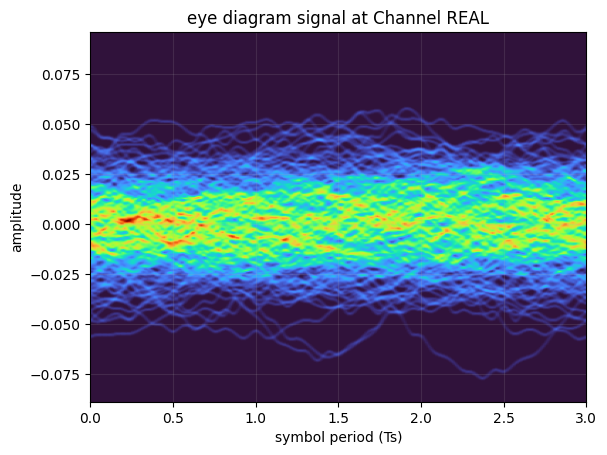

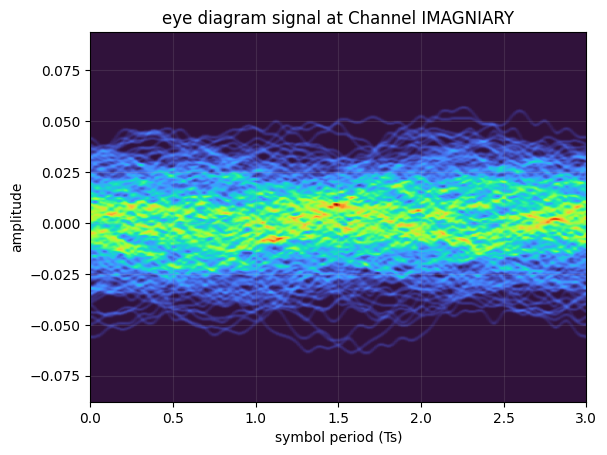

In [954]:
# plot received constellations
pconst(sigCh[0::SpS], R=3);

#Eye Diagram
# plotting eye diagrams of sigTx
discard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigCh.real[discard:-discard], sigCh.real.size-2*discard, SpS, plotlabel='signal at Channel REAL', ptype='fancy')
eyediagram(sigCh.imag[discard:-discard], sigCh.imag.size-2*discard, SpS, plotlabel='signal at Channel IMAGNIARY', ptype='fancy')

# Coherent Detection, DSP and Data Demodulation (Reciever)

Local oscillator P: 2.00 dBm, lw: 100.00 kHz, FO: -128.00 MHz



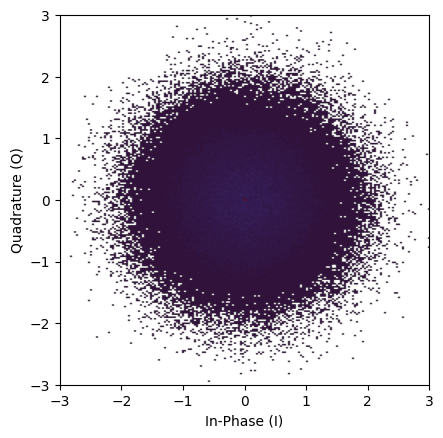

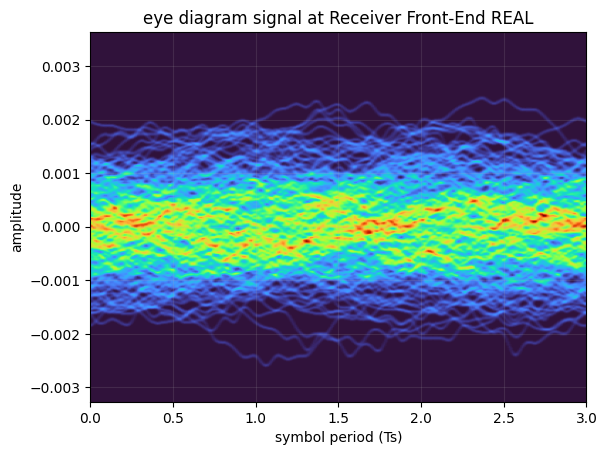

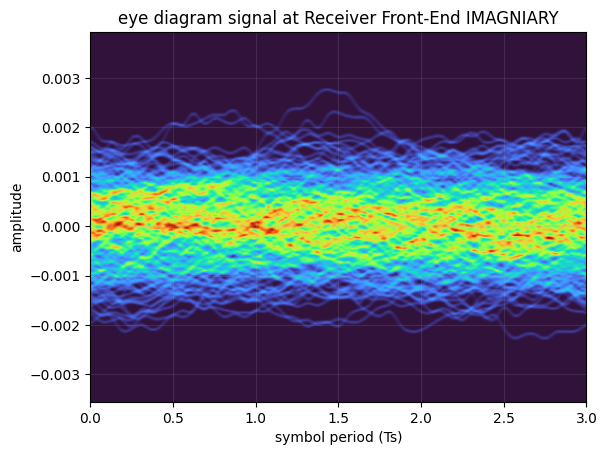

In [955]:

# ----------------------------------------------------------
# 1) Local Oscillator parameters and basic Laser Model Output
# ----------------------------------------------------------

# local oscillator (LO) parameters:
FO  = -128e6                 # frequency offset
paramLO = parameters()
paramLO.P =2              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigCh)
paramLO.Fs = Fs
paramLO.seed = 789 # random seed for noise generation
paramLO.freqShift = 0 + FO  # downshift of the channel to be demodulated add frequency offset

# generate CW laser LO field
sigLO = basicLaserModel(paramLO)

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# -----------------------------------------------------------------------
# 2) Front-End Parameters and photodiode paramters
# ------------------------------------------------------------------------

# Frontend parameters
paramFE = parameters()
paramFE.Fs = Fs

# Photodiodes parameters
paramPD = parameters()
paramPD.B = Rs
paramPD.Fs = Fs
paramPD.ideal = True
paramPD.seed = 1011

# ------------------------------------------------------------------------------------------------
# 3) Coherent Reciever for single-polarization. 
# ------------------------------------------------------------------------------------------------
# Contains a 90 hybrid, two balanced photodiodes and iqmixing
sigRxFrontEnd = coherentReceiver(sigCh, sigLO, paramFE, paramPD)

# plot received constellations
pconst(sigRxFrontEnd[0::SpS],R =3)

#Eye Diagram
discard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigRxFrontEnd.real[discard:-discard], sigRxFrontEnd.real.size-2*discard, SpS, plotlabel='signal at Receiver Front-End REAL', ptype='fancy')
eyediagram(sigRxFrontEnd.imag[discard:-discard], sigRxFrontEnd.imag.size-2*discard, SpS, plotlabel='signal at Receiver Front-End IMAGNIARY', ptype='fancy')


Matched filtering took 0.52 seconds.


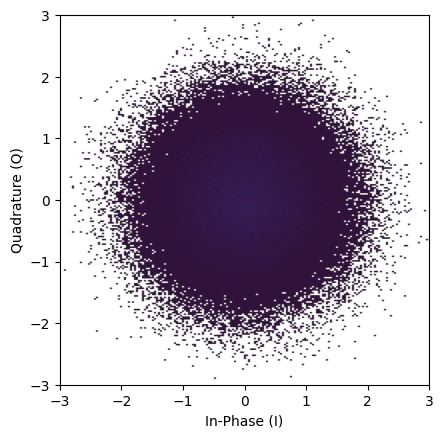

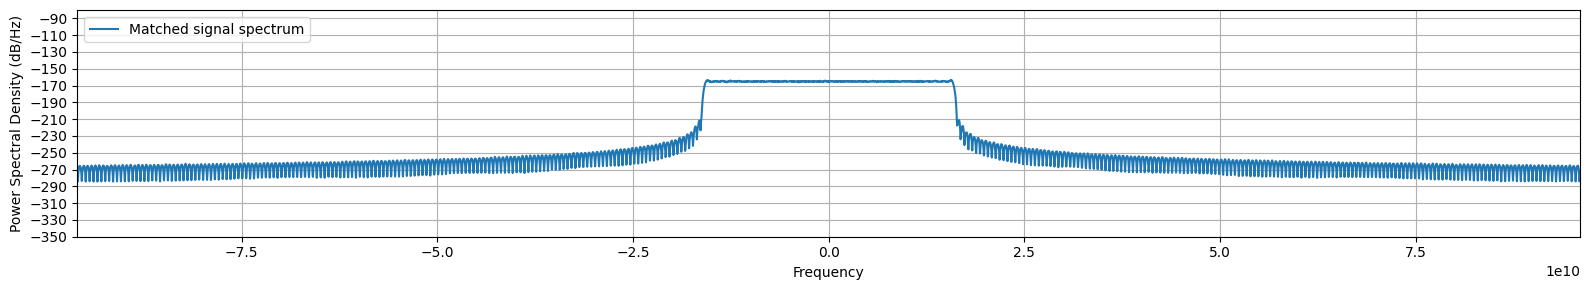

In [956]:
# ------------------------------------------------------------------------------------------------
# 4) Rx Filtering - Matched Filtering
# ------------------------------------------------------------------------------------------------

paramRxPulse = parameters()
paramRxPulse.SpS = SpS
paramRxPulse.nFilterTaps = nFilterTaps
paramRxPulse.rollOff = rollOff
paramRxPulse.pulseType = "rrc"
pulse = pulseShape(paramRxPulse) 

start = time.time()
sigRxPulseShape = firFilter(pulse, sigRxFrontEnd)
end = time.time()
timeMF = end - start
print(f"Matched filtering took {timeMF:.2f} seconds.")

# plot constellations after matched filtering
pconst(sigRxPulseShape[0::SpS], R=3)

# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-350, -80)
ax.psd(sigRxPulseShape, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='Matched signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

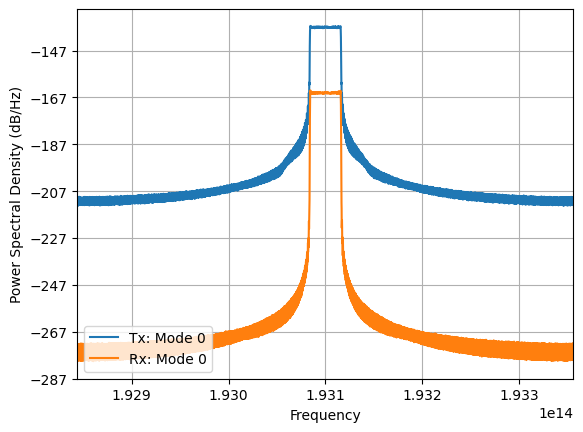

In [957]:
# plot psd
Fs = paramCh.Fs
fig = plotPSD(sigTxo, Fs, paramCh.Fc, label='Tx'); 
fig = plotPSD(sigRxPulseShape, Fs, paramCh.Fc, fig=fig, label='Rx');
ax.set_title('optical WDM spectrum');

In [958]:
# ------------------------------------------------------------------------------------------------
# 5) Decimation to 2 samples/symbol
# ------------------------------------------------------------------------------------------------
paramDec = parameters()
paramDec.SpSin  = SpS
paramDec.SpSout = 2

start = time.time()
sigRxDecimation = decimate(sigRxPulseShape, paramDec)
end = time.time()
timeDec = end - start
print(f"Decimation took {timeDec:.2f} seconds.")
print(len(sigRxDecimation))

Decimation took 0.07 seconds.
400000


Running CD compensation...
CD filter length: 224 taps, FFT size: 256


CD compensation took 0.24 seconds.


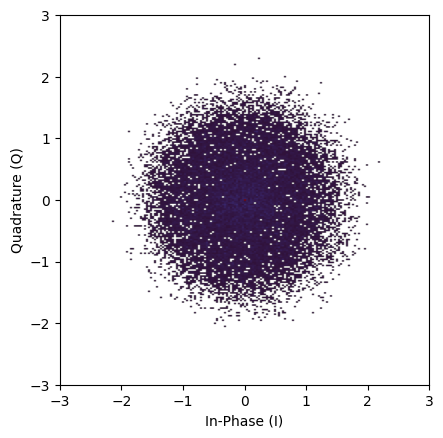

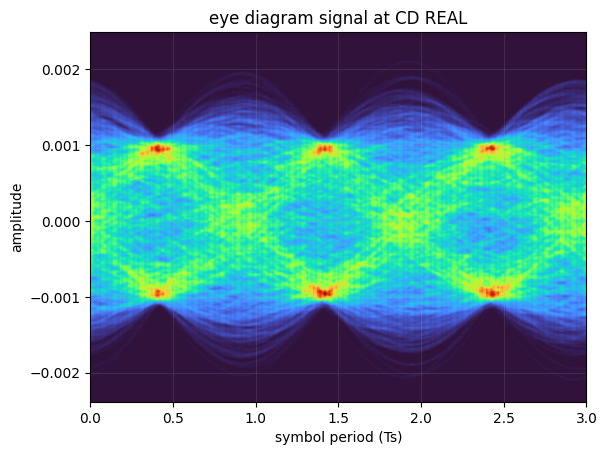

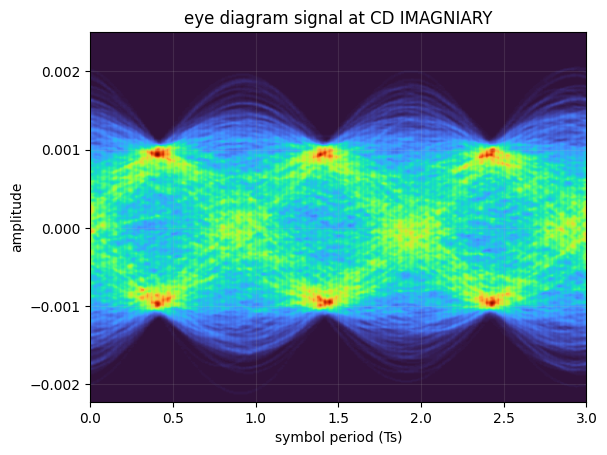

In [959]:
# ------------------------------------------------------------------------------------------------
# 6) Chromatic Dispersion Compensation for non-linear channel
# ------------------------------------------------------------------------------------------------
paramEDC = parameters()
paramEDC.L = paramCh.Ltotal
paramEDC.D = paramCh.D
paramEDC.Fc = paramCh.Fc
paramEDC.Rs = Rs
paramEDC.Fs = 2*Rs

start = time.time()
sigRxCD = edc(sigRxDecimation, paramEDC)
end = time.time()
timeCDcomp = end - start
print(f"CD compensation took {timeCDcomp:.2f} seconds.")

# plot constellations after CD compensation
pconst(sigRxCD[0::SpS], R=3);

# re-synchronization with transmitted sequences
symbRxCD = symbolSync(sigRxCD, symbTx, 2)

# Eye diagram
discard = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigRxCD.real[discard:-discard], sigRxCD.real.size-2*discard, paramDec.SpSout, plotlabel='signal at CD REAL', ptype='fancy')
eyediagram(sigRxCD.imag[discard:-discard], sigRxCD.imag.size-2*discard, paramDec.SpSout, plotlabel='signal at CD IMAGNIARY', ptype='fancy')


In [960]:
# ------------------------------------------------------------------------------------------------
# 7) Power Normalization
# ------------------------------------------------------------------------------------------------
x = pnorm(sigRxCD) 
d = pnorm(symbRxCD)

Running adaptive equalizer...
cma - training stage #0
cma pre-convergence training iteration #0
cma MSE = 0.014753.
cma pre-convergence training iteration #1
cma MSE = 0.011989.
cma - training stage #1
cma MSE = 0.031153.


Adaptive equalization took 0.38 seconds.


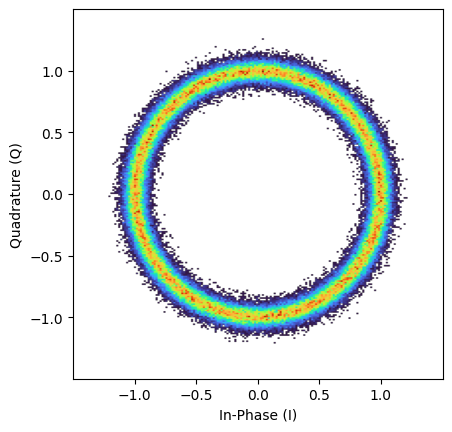

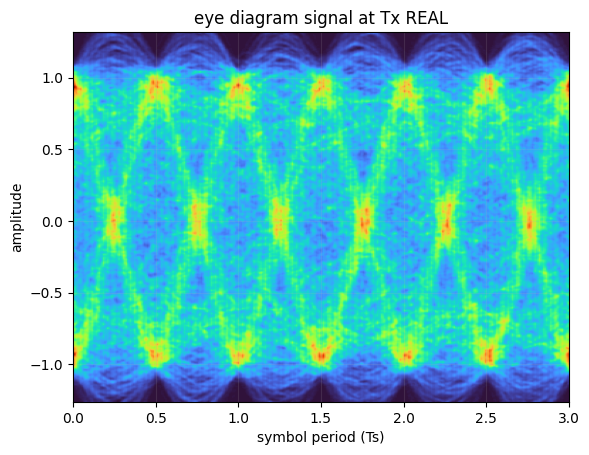

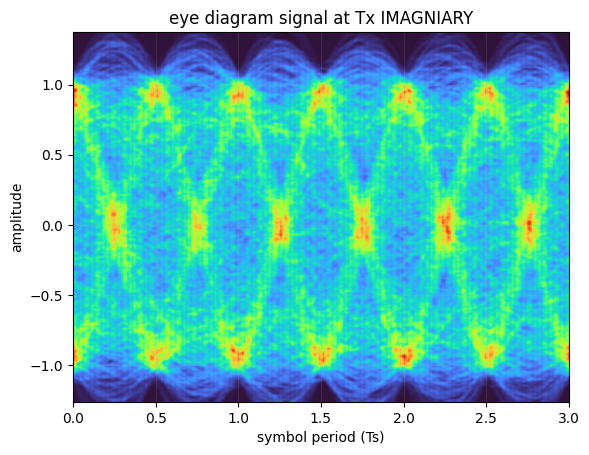

In [961]:
# ------------------------------------------------------------------------------------------------
# 8) Adaptive Equalization Parameters
# ------------------------------------------------------------------------------------------------
paramEq = parameters()
paramEq.nTaps = 35
paramEq.SpS = paramDec.SpSout
paramEq.numIter = 2
paramEq.storeCoeff = False
paramEq.M = M
paramEq.shapingFactor = 0
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.constType = "qam"
paramEq.prgsBar = False

if M == 4:
    paramEq.alg = ['cma','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3]
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 5e-4] 

start = time.time()
y_EQ = mimoAdaptEqualizer(x, paramEq, d)
end = time.time()
timeEq = end - start
print(f"Adaptive equalization took {timeEq:.2f} seconds.")

#plot constellations after adaptive equalization
discard = 5000
pconst(y_EQ[discard:-discard], R=1.5);

# Eye diagram
discard2 = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(y_EQ.real[discard2:-discard2], y_EQ.real.size-2*discard2, paramDec.SpSout, plotlabel='signal at Tx REAL', ptype='fancy')
eyediagram(y_EQ.imag[discard2:-discard2], y_EQ.imag.size-2*discard2, paramDec.SpSout, plotlabel='signal at Tx IMAGNIARY', ptype='fancy')

Running frequency offset compensation...
Estimated frequency offset (MHz): [128.04]
Running BPS carrier phase recovery...
Estimated linewidth: 209.482 kHz


CPR took 2.17 seconds.


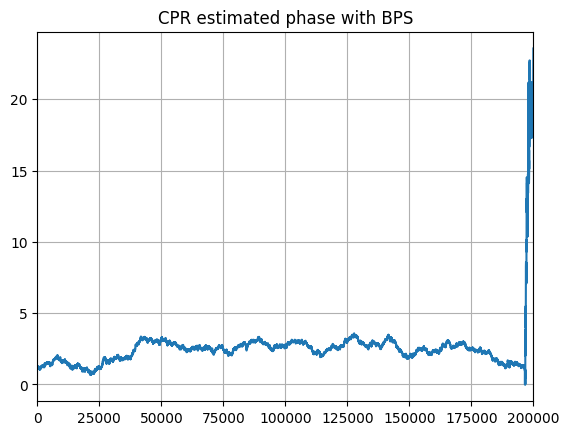

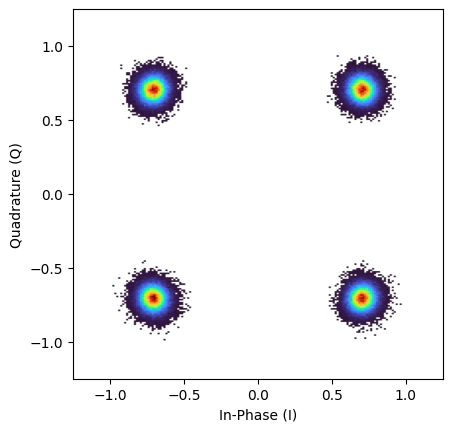

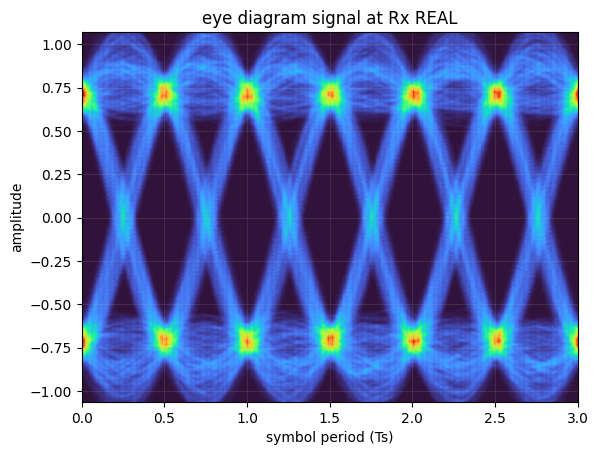

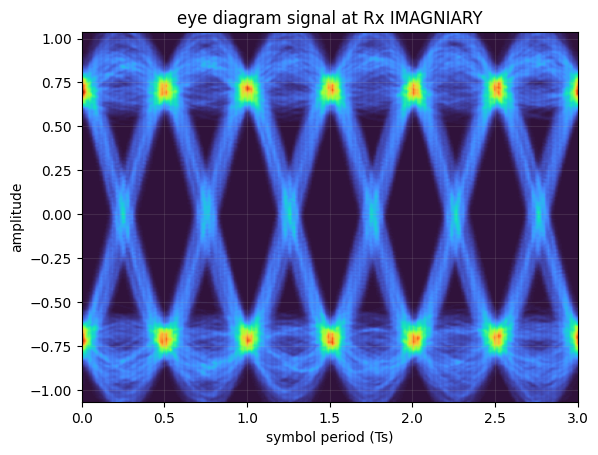

In [962]:
# ------------------------------------------------------------------------------------------------
# 9) Carrier and phase recovery trials
# ------------------------------------------------------------------------------------------------
# Trial 1 with bps

paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = M
paramCPR.constType ="qam"
paramCPR.shapingFactor = 0
paramCPR.N   = 41
paramCPR.B   = 64
paramCPR.returnPhases = True
paramCPR.Ts = 1/Rs

start = time.time()
y_CPR_1, θ = cpr(y_EQ, paramCPR)
end = time.time()
timeCPR = end - start
print(f"CPR took {timeCPR:.2f} seconds.")

plt.figure()
plt.title('CPR estimated phase with BPS')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000
# plot constellations
pconst(y_CPR_1[discard:-discard])

# plotting eye diagrams of sigTx
eyediagram(y_CPR_1.real[discard:-discard], y_CPR_1.real.size-2*discard, paramDec.SpSout, plotlabel='signal at Rx REAL', ptype='fancy')
eyediagram(y_CPR_1.imag[discard:-discard], y_CPR_1.imag.size-2*discard, paramDec.SpSout, plotlabel='signal at Rx IMAGNIARY', ptype='fancy')


In [ ]:
"""Performance Metric Exploration for Single Polarization
"""
discard = 5000
ind = np.arange(discard, len(symbTx) - discard)

# remove phase ambiguity for 4-QAM/QPSK
if M == 4:
    # reference symbols
    d = symbTx

    # estimate constant complex rotation (and scale) between Rx and Tx
    rot = np.mean(pnorm(d[ind]) / pnorm(y_CPR_1[ind]))

    # undo rotation/scale
    y_CPR_1_corr = pnorm(rot * y_CPR_1)
else:
    y_CPR_1_corr = pnorm(y_CPR_1)

# now compute metrics (both are 1 sample/symbol and same length)
BER, SER, SNR = fastBERcalc(y_CPR_1_corr[ind], pnorm(symbTx)[ind], M, 'qam', px = paramSymb.px)
EVM = calcEVM(y_CPR_1_corr[ind], M, 'qam', pnorm(symbTx)[ind])
Qfactor = ber2Qfactor(BER[0])

print(' SER: %.3e,  '%(SER[0]))
print(' BER: %.3e   '%(BER[0]))
print(' SNR: %.3f dB'%(SNR[0]))
print(' EVM: %.3f %%'%(EVM[0]*100))
print(' Qfactor: %.3f,  '%(Qfactor))


 SER: 7.488e-01,  
 BER: 4.994e-01   
 SNR: -3.001 dB
 EVM: 100.000 %
 Qfactor: -28.383,  


Running frequency offset compensation...
Estimated frequency offset (MHz): [128.04]
Running Viterbi&Viterbi carrier phase recovery...
Estimated linewidth: 2.651 kHz


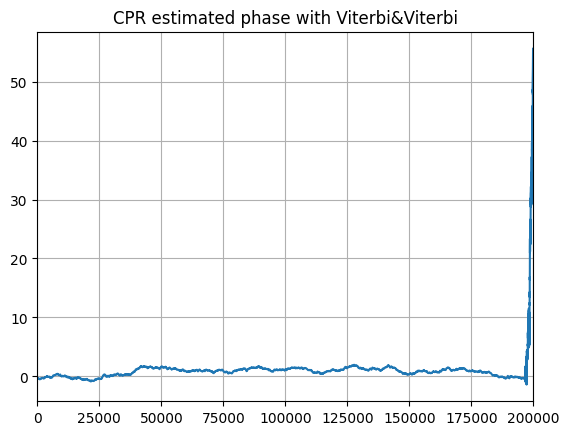

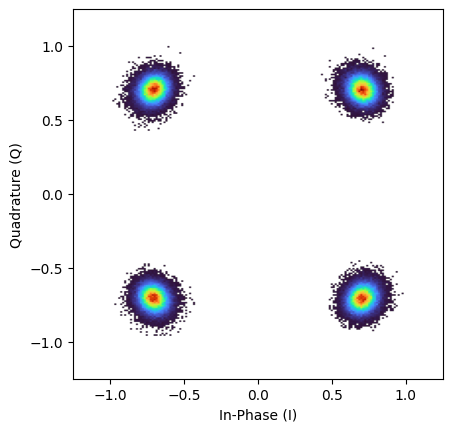

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [964]:
# ------------------------------------------------------------------------------------------------
# 9) Carrier and phase recovery trials
# ------------------------------------------------------------------------------------------------
# Trial 2 Viterbi
paramCPR = parameters()
paramCPR.shapingFactor = 0
paramCPR.alg = 'viterbi'
paramCPR.N = 151
paramCPR.returnPhases = True
paramCPR.M   = M
paramCPR.constType ="qam"
paramCPR.Ts = 1/Rs

y_CPR_2, θ = cpr(y_EQ, paramCPR)


plt.figure()
plt.title('CPR estimated phase with Viterbi&Viterbi')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000

# plot constellations
pconst(y_CPR_2[discard:-discard])

In [965]:
"""Performance Metric Exploration for Single Polarization
"""
discard = 5000
ind = np.arange(discard, len(symbTx) - discard)

# remove phase ambiguity for 4-QAM/QPSK
if M == 4:
    # reference symbols
    d = symbTx

    # estimate constant complex rotation (and scale) between Rx and Tx
    rot = np.mean(pnorm(d[ind]) / pnorm(y_CPR_2[ind]))

    # undo rotation/scale
    y_CPR_2_corr = pnorm(rot * y_CPR_2)
else:
    y_CPR_2_corr = pnorm(y_CPR_2)

# now compute metrics (both are 1 sample/symbol and same length)
BER, SER, SNR = fastBERcalc(y_CPR_2_corr[ind], pnorm(symbTx)[ind], M, 'qam', px = paramSymb.px)
EVM = calcEVM(y_CPR_2_corr[ind], M, 'qam', pnorm(symbTx)[ind])
Qfactor = ber2Qfactor(BER[0])

print(' SER: %.3e,  '%(SER[0]))
print(' BER: %.3e   '%(BER[0]))
print(' SNR: %.3f dB'%(SNR[0]))
print(' EVM: %.3f %%'%(EVM[0]*100))
print(' Qfactor: %.3f,  '%(Qfactor))


 SER: 7.488e-01,  
 BER: 4.994e-01   
 SNR: -2.999 dB
 EVM: 99.999 %
 Qfactor: -28.383,  


# Time taken for all of the system to simulate

In [966]:
print(f"{'-'*42}")
print(f"| {'DSP execution time benchmark':<30} | {'Time':<5} |")
print(f"| {'-'*30} | {'-'*5} |")
print(f"| {'Matched filtering':<30} | {timeMF:.2f} s|")
print(f"| {'CD compensation':<30} | {timeCDcomp:.2f} s|")
print(f"| {'Decimation':<30} | {timeDec:.2f} s|")
print(f"| {'Adaptive equalization':<30} | {timeEq:.2f} s|")
print(f"| {'Carrier phase recovery':<30} | {timeCPR:.2f} s|")
print(f"{'-'*42}")
print(f"| {'Total':<30} | {timeMF + timeCDcomp + timeDec + timeEq + timeCPR:.2f} s|")
print(f"{'-'*42}")

------------------------------------------
| DSP execution time benchmark   | Time  |
| ------------------------------ | ----- |
| Matched filtering              | 0.52 s|
| CD compensation                | 0.24 s|
| Decimation                     | 0.07 s|
| Adaptive equalization          | 0.38 s|
| Carrier phase recovery         | 2.17 s|
------------------------------------------
| Total                          | 3.37 s|
------------------------------------------
